In [1]:
import os
import numpy as np
import pandas as pd
import papyrus_scripts
import matplotlib.pyplot as plt
import seaborn as sns
from papyrus_scripts.reader import read_papyrus, read_protein_set

# EquiVS data

In [117]:
# extract the HGNC ID from the target folder
hgnc_target = os.listdir(path='EquiVS_data/target/')
hgnc_target = [x.split('.')[0] for x in hgnc_target]
with open('hgnc_id.txt', 'w') as f:
    for item in hgnc_target:
        f.write("%s\n" % item)
f.close()

In [14]:
# Use Togo ID tool (https://togoid.dbcls.jp/) for ID mapping (HGNC->Uniprot)
df = pd.read_csv('EquiVS_data/hgnc_uniprot_mapping.csv')
with open('EquiVS_data/uniprot_id.txt', 'w') as f:
    for item in df['UniProt'].values:
        f.write("%s\n" % item)
f.close()

In [119]:
df

,HGNC gene symbol,UniProt
0,ABCB1,P08183
1,ABCB11,O95342
2,ABCC1,P33527
3,ABCC2,Q92887
4,ABCC3,O15438
...,...,...
911,XBP1,P17861
912,XDH,P47989
913,XIAP,P98170
914,YES1,P07947


In [15]:
# Get protein sequences from Uniprot
protein_data = pd.read_csv('EquiVS_data/protein_seq.tsv', sep='\t')
protein_data['Organism'] = protein_data['Entry Name'].str.split('_').str[1]
protein_data['UniProt_ID'] = protein_data['Entry']

target_hgnc = dict(zip(df['UniProt'], df['HGNC gene symbol']))
protein_data['HGNC_ID'] = protein_data['From'].map(target_hgnc)
protein_data = protein_data[['UniProt_ID', 'HGNC_ID', 'Sequence', 'Organism']]

In [3]:
df_all = pd.DataFrame()
for target in os.listdir(path='EquiVS_data/target/'):
    df = pd.read_csv('EquiVS_data/target/' + target)
    df['HGNC gene symbol'] = target.split('.')[0].upper()
    df_all = pd.concat([df_all, df], axis=0)

In [55]:
hgnc_uni = dict(zip(protein_data['HGNC_ID'], protein_data['UniProt_ID']))
hgnc_seq = dict(zip(protein_data['HGNC_ID'], protein_data['Sequence']))
hgnc_org = dict(zip(protein_data['HGNC_ID'], protein_data['Organism']))
df_all['UniProt_ID'] = df_all['HGNC gene symbol'].map(hgnc_uni)
df_all['Sequence'] = df_all['HGNC gene symbol'].map(hgnc_seq)
df_all['Organism'] = df_all['HGNC gene symbol'].map(hgnc_org)

In [110]:
print(len(df_all))
df_all = df_all[df_all['Activity type'].isin(['pIC50', 'pEC50', 'pKi', 'pKd'])]
print(len(df_all))
data_curated = df_all[df_all['UniProt_ID'].notnull()]
print(len(data_curated))

1353120
1353120
1312515


In [111]:
data_curated['PubChem ID'] = data_curated['PubChem ID'].astype(str)
data_curated['IUPHAR ID'] = data_curated['IUPHAR ID'].astype(str)

def join_strings(arr):
    valid_strings = [str(x) for x in arr if x != "nan"]
    return ";".join(valid_strings)

activity_id = np.apply_along_axis(join_strings, axis=1, arr=data_curated.iloc[:, :3].values)
data_curated['Activity_ID'] = activity_id

In [112]:
data_curated = data_curated.rename(columns={'Activity type': 'Activity_Type',
                                            'Final Activity': 'Activity_Value',
                                            'HGNC gene symbol': 'HGNC_ID',
                                            'Source': 'source'})

In [114]:
data_curated['CID'] = None
data_curated['target_id'] = None
data_curated[['Activity_ID', 'source', 'Activity_Type',
              'Activity_Value', 'SMILES',
              'CID', 'target_id', 'UniProt_ID', 
              'HGNC_ID', 'Sequence', 'Organism']].to_csv('Integrated_dataset/equiVS.csv', index=False)

# Papyrus data

In [2]:
# read data (not Papyrus++ version)
dataset = read_papyrus(is3d=False, version='latest',
                       plusplus=False, source_path='D:\Activity Cliff')

MemoryError: Unable to allocate 11.1 GiB for an array with shape (25, 59348304) and data type object

In [3]:
# choose data type in [IC50, EC50, Ki, Kd]
# filter data with high standard deviation
# filter data with relation other than '='
dataset = dataset[dataset['type_other'] == '0']
print(len(dataset))
dataset = dataset[dataset['pchembl_value_StdDev'] < 0.1]
print(len(dataset))
dataset = dataset[dataset['relation'].isin(['=', '>=', '<='])]
print(len(dataset))

1564819
1418456
1114167


In [4]:
def get_activity_type(df):
    if '1' in df['type_KD']:
        return 'pKD'
    elif '1' in df['type_Ki']:
        return 'pKi'
    elif '1' in df['type_IC50']:
        return 'pIC50'
    elif '1' in df['type_EC50']:
        return 'pEC50'
    return None

In [5]:
# integrat data type into a single column
type_list = []
for i in range(len(dataset)):
    type_list.append(get_activity_type(dataset.iloc[i]))

In [6]:
# rename columns
dataset['Activity_Type'] = type_list
dataset = dataset.rename(columns={'pchembl_value_Mean': 'Activity_Value'})

In [140]:
dataset_curated = dataset[['Activity_ID', 'source', 
                           'Activity_Type', 'Activity_Value',
                           'SMILES', 'CID', 'target_id']]

In [141]:
# read protein structure data
protein_data = read_protein_set(source_path='D:\Activity Cliff')

In [142]:
# map current target id to Uniprot ID, HGNC ID, and protein sequence
target_uniprot = dict(zip(protein_data['target_id'], protein_data['UniProtID']))
target_hgnc = dict(zip(protein_data['target_id'], protein_data['HGNC_symbol']))
target_seq = dict(zip(protein_data['target_id'], protein_data['Sequence']))
dataset_curated['UniProt_ID'] = dataset['target_id'].map(target_uniprot)
dataset_curated['HGNC_ID'] = dataset['target_id'].map(target_hgnc)
dataset_curated['Sequence'] = dataset['target_id'].map(target_seq)

In [143]:
# exract organism information from Uniprot ID
dataset_curated['Organism'] = dataset_curated['UniProt_ID'].apply(lambda x: x.split('_')[1])
dataset_curated['UniProt_ID'] = dataset_curated['UniProt_ID'].apply(lambda x: x.split('_')[0])

In [154]:
dataset_curated['UniProt_ID'] = dataset_curated['target_id'].map(lambda x: x.split('_')[0])
dataset_curated['Activity_Type'] = dataset_curated['Activity_Type'].map(lambda x: 'pKd' if x == 'pKD' else x)
dataset_curated[['Activity_ID', 'source', 'Activity_Type', 'Activity_Value',
                'SMILES', 'CID', 'target_id', 'UniProt_ID', 'HGNC_ID',
                'Sequence', 'Organism']].to_csv('Integrated_dataset/papyrus.csv', index=False)

# Check molecule structure

In [2]:
import molvs
from rdkit import Chem

In [3]:
data_curated = pd.read_csv('Integrated_dataset/equiVS.csv')
dataset_curated = pd.read_csv('Integrated_dataset/papyrus.csv')
print(f'EquiVS: {len(data_curated)}')
print(f'Papyrus: {len(dataset_curated)}')

EquiVS: 1312515
Papyrus: 1114167


In [4]:
equivs = data_curated['UniProt_ID'].unique()
papyrus = dataset_curated['UniProt_ID'].unique()
print(f'EquiVS Num. Protein: {len(equivs)}')
print(f'Papyrus Num. Protein: {len(papyrus)}')
equivs = data_curated['SMILES'].unique()
papyrus = dataset_curated['SMILES'].unique()
print(f'EquiVS Num. Compound: {len(equivs)}')
print(f'Papyrus Num. Compound: {len(papyrus)}')

EquiVS Num. Protein: 895
Papyrus Num. Protein: 6492
EquiVS Num. Compound: 587408
Papyrus Num. Compound: 597530


In [7]:
# standardize SMILES using MolVS
def molecule_standardizer(smiles):
    if Chem.MolFromSmiles(smiles) is None:
        return None
    return molvs.standardize_smiles(smiles)

smiles_list = pd.DataFrame(list(set(data_curated['SMILES'].unique()) 
                                | set(dataset_curated['SMILES'].unique())), columns=['Pre'])
smiles_list['After'] = smiles_list['Pre'].map(molecule_standardizer)
print(len(smiles_list))
smiles_list = smiles_list[smiles_list['After'].notnull()]
print(len(smiles_list))

smiles_dict = dict(zip(smiles_list['Pre'], smiles_list['After']))
data_curated['SMILES'] = data_curated['SMILES'].map(smiles_dict)
dataset_curated['SMILES'] = dataset_curated['SMILES'].map(smiles_dict)

[22:52:51] Can't kekulize mol.  Unkekulized atoms: 3 10
[23:01:48] Unusual charge on atom 4 number of radical electrons set to zero
[23:01:48] Unusual charge on atom 0 number of radical electrons set to zero
[23:01:48] Unusual charge on atom 16 number of radical electrons set to zero
[23:01:48] Unusual charge on atom 16 number of radical electrons set to zero


934863
934863


## Visualization

In [20]:
def plot_activity_distribution(df1, df2, type):
    # sns.set_style("whitegrid")
    
    plt.figure(figsize=(10, 6))

    plt.hist(df1['Activity_Value'], bins=69,
              alpha=0.5, color = '#6a3d9a', label='EquiVS')
    plt.hist(df2['Activity_Value'], bins=50, alpha=0.5, color = '#33a02c', label='Papyrus')

    plt.legend(loc='upper right', fontsize=12)

    if type == 'pKi':
        plt.xlabel(r'Bioactivity value: $K_{i}$ ($-log_{10}nM$)', fontsize=14)
    elif type == 'pKd':
        plt.xlabel(r'Bioactivity value: $K_{d}$ ($-log_{10}nM$)', fontsize=14)
    elif type == 'pIC50':
        plt.xlabel(r'Bioactivity value: $IC_{50}$ ($-log_{10}nM$)', fontsize=14)
    elif type == 'pEC50':
        plt.xlabel(r'Bioactivity value: $EC_{50}$ ($-log_{10}nM$)', fontsize=14)
        
    plt.ylabel('Count', fontsize=14)
    
    sns.despine()
    
    plt.tight_layout()

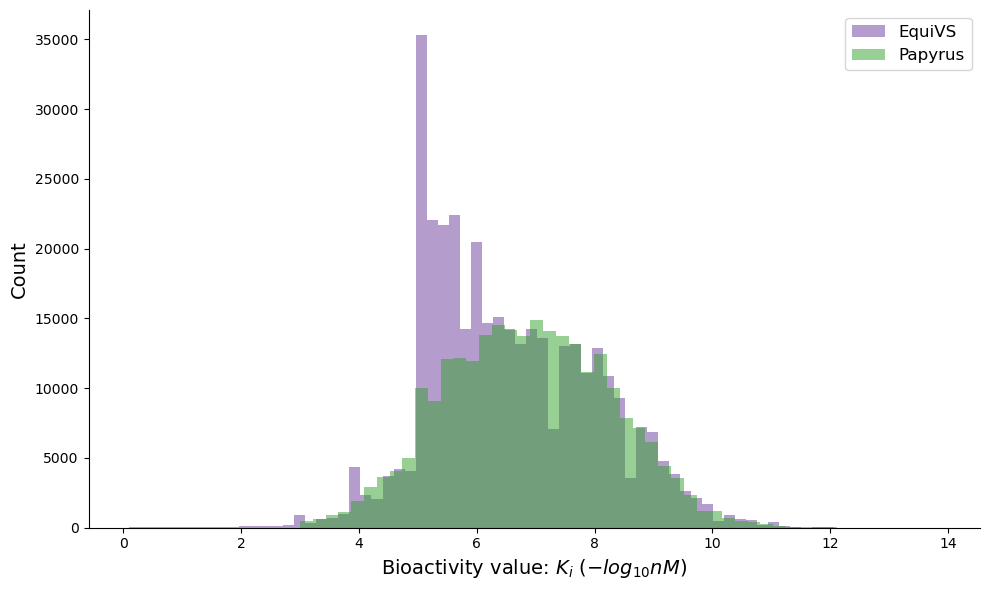

In [90]:
# simple visualization
type = 'pKi'
plot_activity_distribution(data_curated[data_curated['Activity_Type']==type], 
                           dataset_curated[dataset_curated['Activity_Type']==type], type)
plt.savefig(f'Figure/{type}_distribution.png', dpi=300)

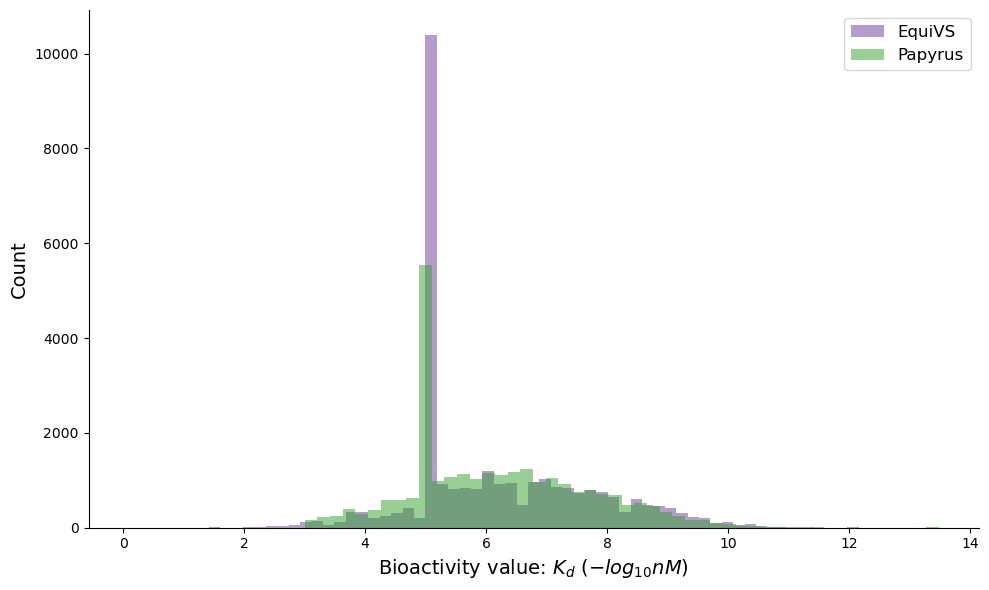

In [91]:
type = 'pKd'
plot_activity_distribution(data_curated[data_curated['Activity_Type']==type], 
                           dataset_curated[dataset_curated['Activity_Type']==type], type)
plt.savefig(f'Figure/{type}_distribution.png', dpi=300)

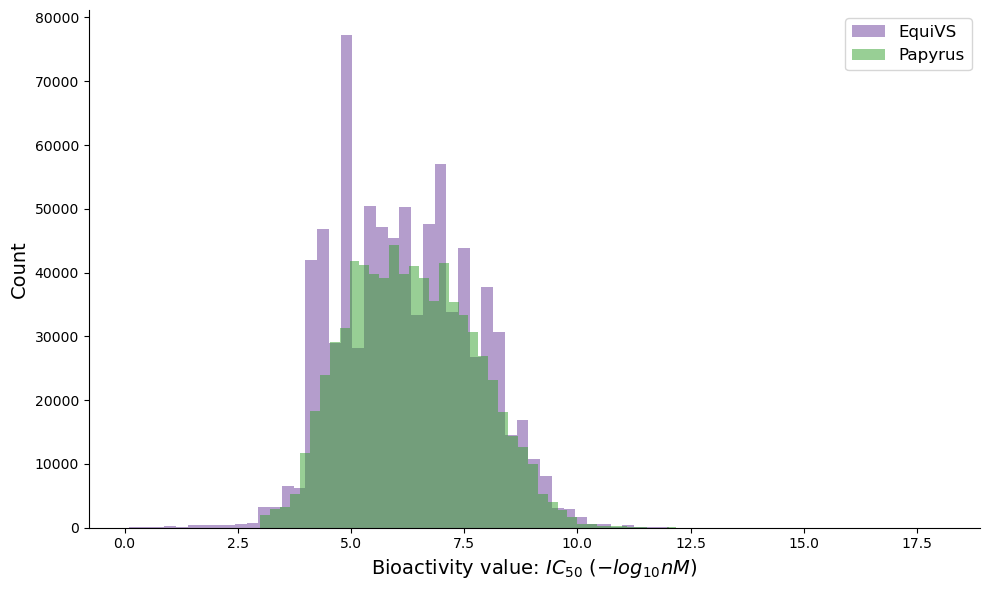

In [92]:
type = 'pIC50'
plot_activity_distribution(data_curated[data_curated['Activity_Type']==type], 
                           dataset_curated[dataset_curated['Activity_Type']==type], type)
plt.savefig(f'Figure/{type}_distribution.png', dpi=300)

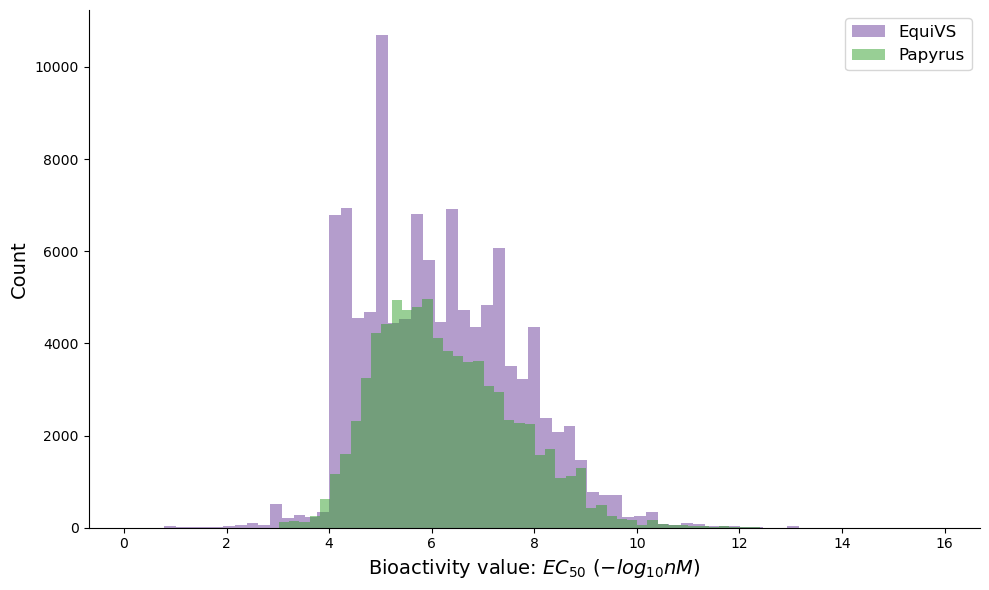

In [93]:
type = 'pEC50'
plot_activity_distribution(data_curated[data_curated['Activity_Type']==type], 
                           dataset_curated[dataset_curated['Activity_Type']==type], type)
plt.savefig(f'Figure/{type}_distribution.png', dpi=300)

In [114]:
from matplotlib_venn import venn2

def plot_venn(df1, df2, column_name):
    """
    Plot Venn diagram for two datasets.
    param:
        df1: dataframe 1
        df2: dataframe 2
        column_name: column name for comparison
    """
    # Set figure size and style
    plt.figure(figsize=(4, 4))
    sns.set_style("whitegrid")
    
    set1 = set(df1[column_name])
    set2 = set(df2[column_name])
    
    # Plot the Venn diagram
    v = venn2([set1, set2], ('EquiVS', 'Papyrus'), 
              set_colors=('#6a3d9a', '#33a02c'), alpha=0.5)
    
    # Adjust the font size of the labels
    for text in v.set_labels:
        text.set_fontsize(14)
    for text in v.subset_labels:
        text.set_fontsize(14)
    
    # Display the plot
    # plt.title("Venn Diagram of EquiVS and Papyrus", fontsize=16)
    plt.tight_layout()

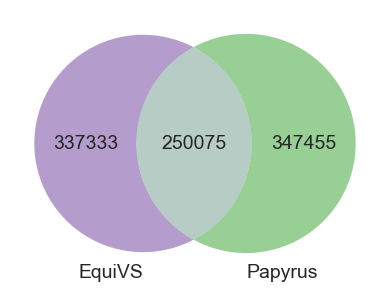

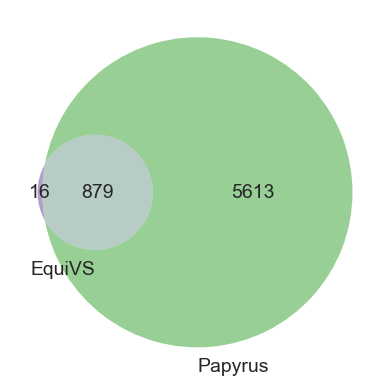

In [115]:
plot_venn(data_curated, dataset_curated, 'SMILES')
plt.savefig('Figure/venn_SMILES.png', dpi=300)
plt.show()
plot_venn(data_curated, dataset_curated, 'UniProt_ID')
plt.savefig('Figure/venn_Protein.png', dpi=300)
plt.show()

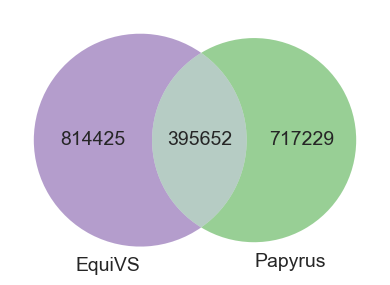

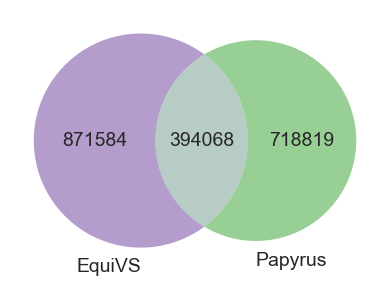

In [130]:
def plot_venn_multi(df1, df2, *args):
    """
    Plot Venn diagram for two datasets based on overlap of multiple columns.
    param:
        df1: dataframe 1
        df2: dataframe 2
        *args: column names for comparison
    """
    # Set figure size and style
    plt.figure(figsize=(4, 4))
    sns.set_style("whitegrid")
    
    # Create a unique string identifier based on the values of the columns
    df1['combined'] = df1[list(args)].astype(str).agg('-'.join, axis=1)
    df2['combined'] = df2[list(args)].astype(str).agg('-'.join, axis=1)

    set1 = set(df1['combined'])
    set2 = set(df2['combined'])

    del df1['combined'], df2['combined']

    # Plot the Venn diagram
    v = venn2([set1, set2], ('EquiVS', 'Papyrus'), 
              set_colors=('#6a3d9a', '#33a02c'), alpha=0.5)
    
    # Adjust the font size of the labels
    for text in v.set_labels:
        text.set_fontsize(14)
    for text in v.subset_labels:
        text.set_fontsize(14)
    
    # Display the plot
    plt.tight_layout()


plot_venn_multi(data_curated, dataset_curated, 'SMILES', 'UniProt_ID')
plt.savefig('Figure/venn_SMILES_Protein.png', dpi=300)
plt.show()
plot_venn_multi(data_curated, dataset_curated, 'SMILES', 'UniProt_ID', 'Activity_Type')
plt.savefig('Figure/venn_SMILES_Protein_ActivityType.png', dpi=300)
plt.show()

In [30]:
dataset_curated['UniProt_ID'].value_counts()

UniProt_ID
P42336    11633
P48736     7175
P24941     7124
Q16539     7107
P00533     6702
          ...  
O88855        1
P16788        1
Q96QK1        1
Q99570        1
A4Q9F0        1
Name: count, Length: 6492, dtype: int64

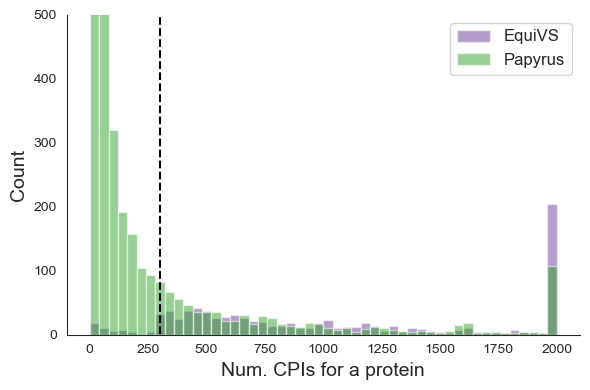

In [105]:
def plot_protein_hist(data1, data2, column_name='UniProt_ID',
                      cutoff=2000, bins=50, vline_pos=300, ylim_max=500):
    """
    Plot histograms for two datasets based on the specified column.
    
    param:
        data1: First dataframe.
        data2: Second dataframe.
        column_name: The column name to plot. Default is 'UniProt_ID'.
        cutoff: Value to cap the data at. Default is 2000.
        bins: Number of bins for the histogram. Default is 50.
        vline_pos: Position of the vertical line on the plot. Default is 300.
        ylim_max: Maximum limit for the y-axis. Default is 500.
    """
    
    # Process data
    num_cpi1 = data1[column_name].value_counts().values
    num_cpi1 = [cutoff if x > cutoff else x for x in num_cpi1]
    
    num_cpi2 = data2[column_name].value_counts().values
    num_cpi2 = [cutoff if x > cutoff else x for x in num_cpi2]
    
    # Plot
    plt.figure(figsize=(6, 4))
    plt.hist(num_cpi1, bins=bins, color='#6a3d9a', alpha=0.5, label='EquiVS')
    plt.hist(num_cpi2, bins=bins, color='#33a02c', alpha=0.5, label='Papyrus')
    plt.vlines(vline_pos, 1, ylim_max * 8, color='black', linestyle='--')
    plt.ylim(0, ylim_max)
    plt.xlabel('Num. CPIs for a protein', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)

    sns.despine()
    plt.tight_layout()

plot_protein_hist(data_curated, dataset_curated, column_name='UniProt_ID')
plt.savefig('Figure/num_cpi.png', dpi=300)
plt.show()

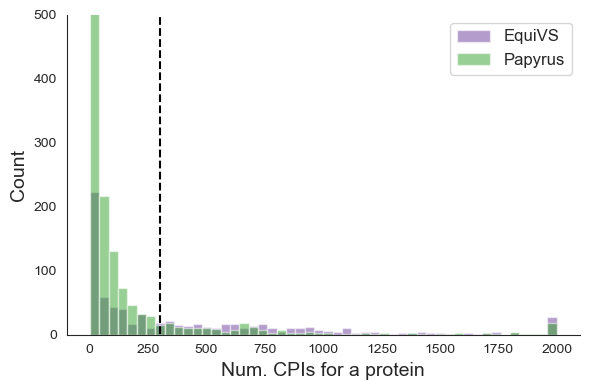

In [112]:
type = 'pKi'
plot_protein_hist(data_curated[data_curated['Activity_Type'] == type],
                 dataset_curated[dataset_curated['Activity_Type'] == type],
                 column_name='UniProt_ID')
plt.savefig(f'Figure/num_cpi_{type}.png', dpi=300)
plt.show()

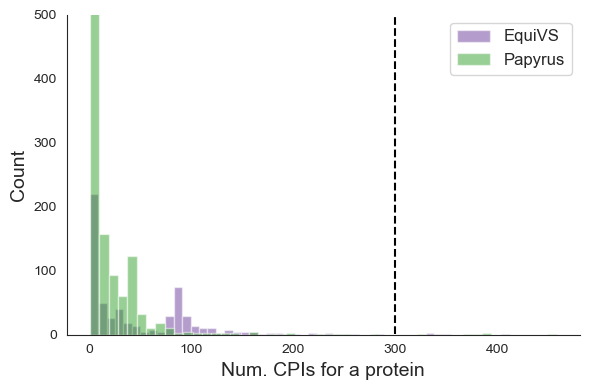

In [111]:
type = 'pKd'
plot_protein_hist(data_curated[data_curated['Activity_Type'] == type],
                 dataset_curated[dataset_curated['Activity_Type'] == type],
                 column_name='UniProt_ID')
plt.savefig(f'Figure/num_cpi_{type}.png', dpi=300)
plt.show()

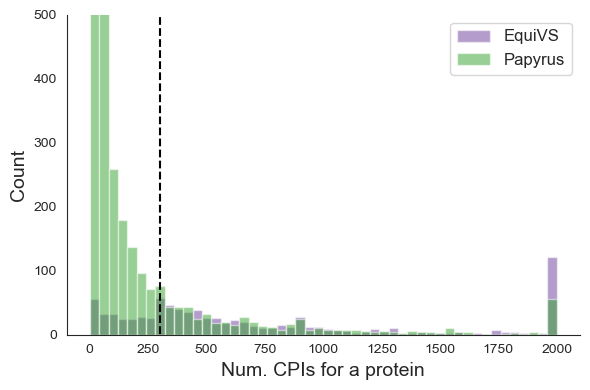

In [110]:
type = 'pIC50'
plot_protein_hist(data_curated[data_curated['Activity_Type'] == type],
                 dataset_curated[dataset_curated['Activity_Type'] == type],
                 column_name='UniProt_ID')
plt.savefig(f'Figure/num_cpi_{type}.png', dpi=300)
plt.show()

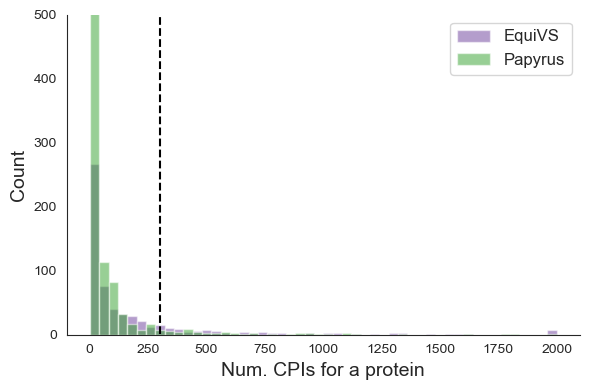

In [113]:
type = 'pEC50'
plot_protein_hist(data_curated[data_curated['Activity_Type'] == type],
                 dataset_curated[dataset_curated['Activity_Type'] == type],
                 column_name='UniProt_ID')
plt.savefig(f'Figure/num_cpi_{type}.png', dpi=300)
plt.show()

In [99]:
import matplotlib.patches as patches

def plot_top_proteins(df, protein_column='protein', top_n=20):
    """
    Plot a horizontal bar chart of the top N most common proteins.
    
    param:
        df: The dataframe containing protein data.
        protein_column: The column name where protein data is stored. Default is 'protein'.
        top_n: Number of top proteins to display. Default is 20.
    """
    # Count proteins and get the top N
    protein_counts = df[protein_column].value_counts().head(top_n)
    
    # Set the style and size of the plot
    plt.figure(figsize=(5, 10))
    
    # Create the barplot with custom colors
    colors = sns.color_palette("tab20", n_colors=top_n)
    ax = sns.barplot(x=protein_counts.values, y=protein_counts.index, palette=colors, edgecolor='w')
    
    # Remove grid, spine and ticks
    sns.despine(left=True, bottom=True, right=True)
    ax.set_xlim(0, 12500)
    ax.yaxis.tick_left()  # only keep y-axis ticks on the left side
    ax.xaxis.tick_bottom()  # only keep x-axis ticks on the bottom
    ax.tick_params(axis='both', which='both', length=0)  # remove tick marks
    
    # Adjust the height of each bar for a reduced width and reduce gap between bars
    bar_height_ratio = 0.3  # Adjust this to control bar thickness
    for patch in ax.patches:
        current_height = patch.get_height()
        diff = current_height - current_height * bar_height_ratio
        patch.set_height(current_height * bar_height_ratio)
        patch.set_y(patch.get_y() + diff * 0.5)  # Adjust the position to center the bar
    
    # Increase font size for x and y axis labels
    ax.set_xlabel('Count', fontsize=16)
    ax.set_ylabel('Protein', fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    
    # Display the plot
    plt.tight_layout()


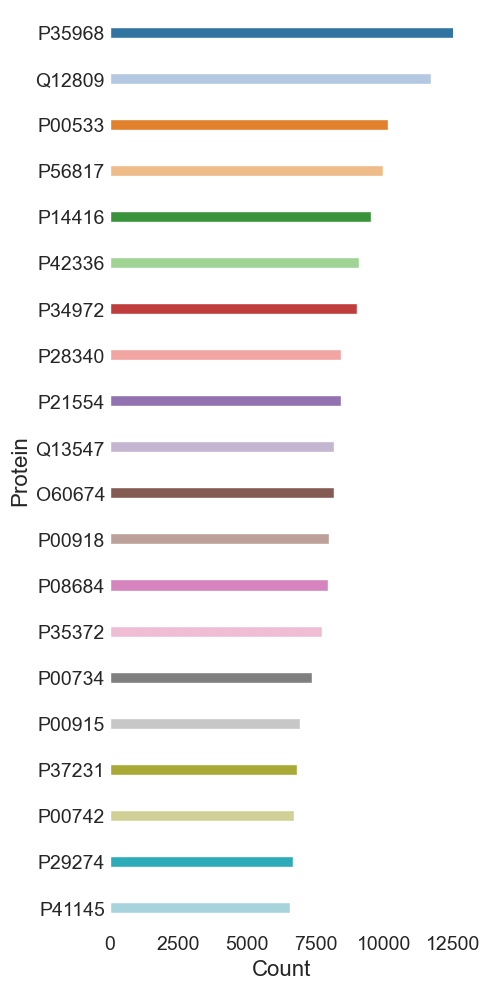

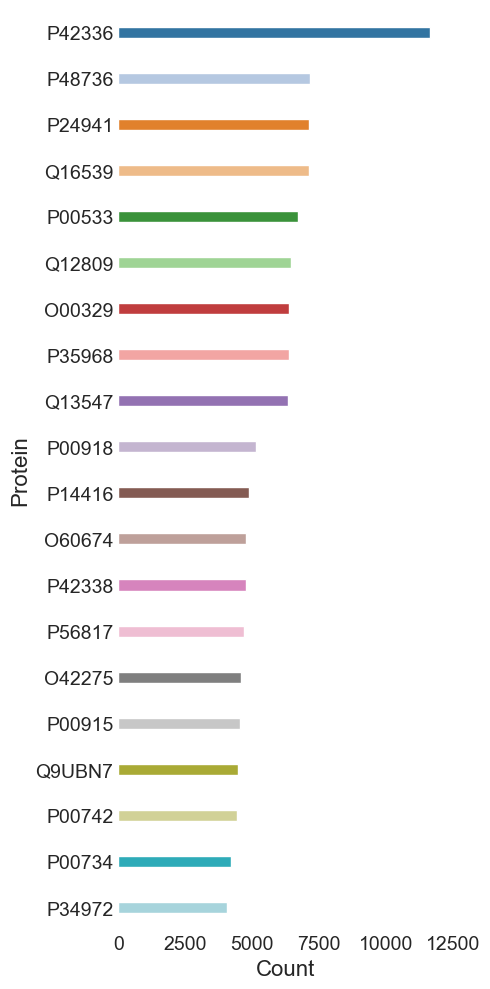

In [100]:
plot_top_proteins(data_curated, protein_column='UniProt_ID', top_n=20)
plt.savefig('Figure/top_protein_EquiVS.png', dpi=300)
plt.show()
plot_top_proteins(dataset_curated, protein_column='UniProt_ID', top_n=20)
plt.savefig('Figure/top_protein_Papyrus.png', dpi=300)
plt.show()

# Integration of dataset

In [9]:
# integrate data
data_curated['Source_2'] = 'EquiVS'
dataset_curated['Source_2'] = 'Papyrus'

integrated_data = pd.concat([data_curated, dataset_curated], axis=0)
integrated_data.to_csv('Integrated_dataset/integrated_data.csv', index=False)

In [10]:
# save smiles dictionary
import pickle

def save_dict(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_dict(dict(zip(smiles_list['After'], smiles_list.index)), 'Integrated_dataset/smiles_dict')

In [14]:
integrated_data[integrated_data['Activity_Type'] == 'pIC50']['SMILES'].value_counts()

SMILES
CN1C(=O)C(N2CCc3cn(CC4CCS(=O)(=O)CC4)nc3C2=O)COc2ccccc21                          319
CN1C(=O)C(N2CCc3c(nn(Cc4ccccc4)c3Br)C2=O)COc2ccccc21                              276
CN1C(=O)C(N2CCc3cn(Cc4ccccc4)nc3C2=O)COc2ccccc21                                  276
CN[C@@H]1C[C@H]2O[C@@](C)([C@@H]1OC)n1c3ccccc3c3c4c(c5c6ccccc6n2c5c31)C(=O)NC4    257
O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12                                        216
                                                                                 ... 
Cc1ccc2[se]n(CCCCn3[se]c4ccc(C)cc4c3=O)c(=O)c2c1                                    1
CC(C)(Oc1ccc(-n2cccn2)cn1)C(=O)N[C@H]1C2CC3CC1C[C@](C(N)=O)(C3)C2                   1
CC(C)(Oc1ccc(Cl)cc1)C(=O)N[C@H]1C2CC3CC1C[C@](CC(=O)O)(C3)C2                        1
CC(C)(Oc1ccc(Cl)cc1)C(=O)N[C@H]1C2CC3CC1C[C@](CCC(=O)O)(C3)C2                       1
COc1ccc(C(=O)c2c(C)n(CCN3CCOCC3)c3cc(C)ccc23)cc1                                    1
Name: count, Length: 676824, dtype: int64